In [117]:
from __future__ import print_function
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D, Input, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import glob
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [7]:
TRAIN_IMAGE_DIR = 'Endoscopy/train/'
TRAIN_MASK_DIR = 'Endoscopy/mask/'
TEST_IMAGE_DIR = 'Endoscopy/test/'
im_width = 128
im_height = 128
border = 5
path_train = 'Endoscopy/train/'
path_test = 'Endoscopy/test/'


In [133]:
def get_data(path, train=True):
    ids = next(os.walk(path + "images"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path + 'mask/' + id_, color_mode = "grayscale"))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 


/home/nebex/usys/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

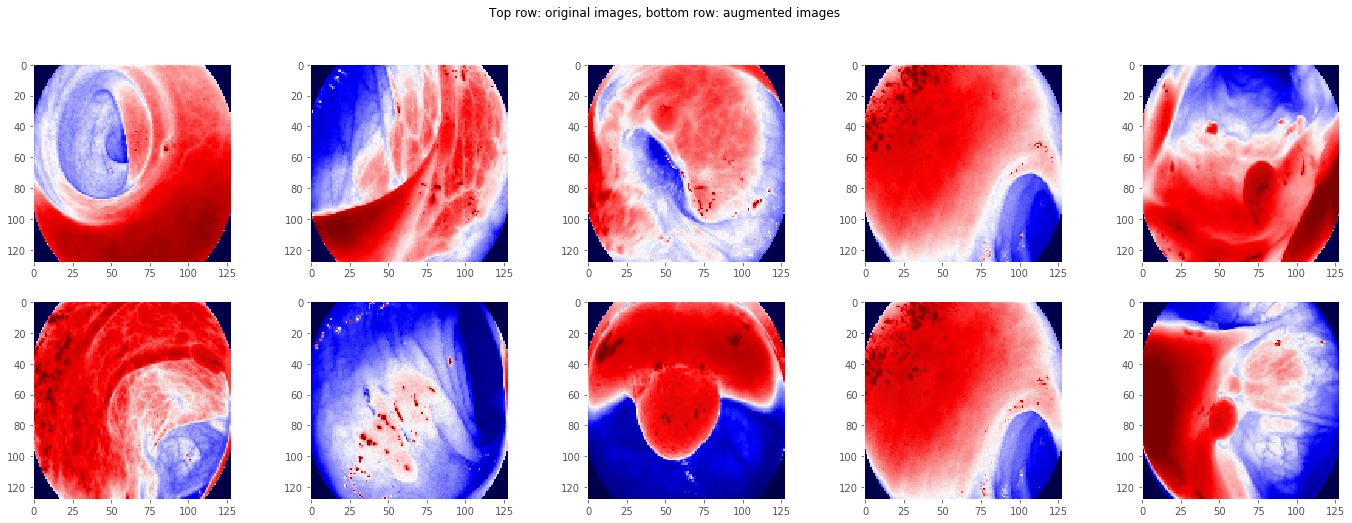

In [157]:
fig, axs = plt.subplots(2, 5, figsize=(24,8))
for i in range(5):
    axs[0][i].imshow(X_train[i].squeeze(), cmap='seismic')
    axs[0][i].imshow(y_train[i].squeeze(), cmap="gray", alpha=0.023)
    axs[1][i].imshow(X_train[int(len(X_train)/2 + i)].squeeze(), cmap="seismic")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="gray", alpha=0.03)
    axs[0][i].grid(False)
    axs[1][i].grid(False)

fig.suptitle("Top row: original images, bottom row: augmented images")

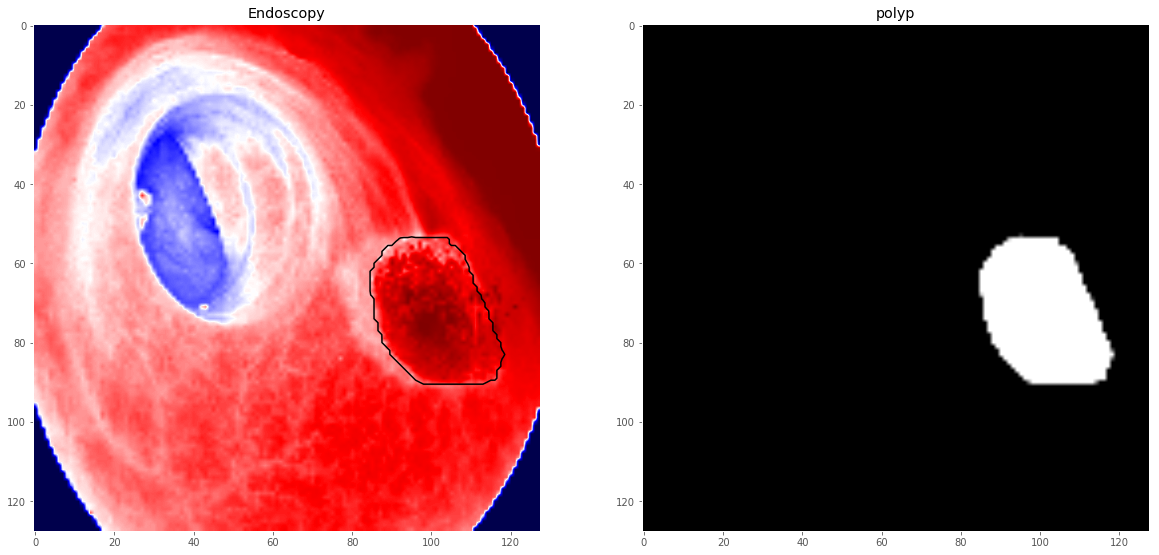

In [143]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Endoscopy')
ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('polyp');
ax[0].grid(False)
ax[1].grid(False)

In [17]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [18]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [19]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, 
                    save_best_only=True, save_weights_only=True)]

In [21]:
nbatch=8
nepoch=40

In [22]:
results = model.fit(X_train, y_train, batch_size=nbatch, epochs=nepoch, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 166 samples, validate on 30 samples
Epoch 1/40
166/166 [==============================] - 17s 103ms/step - loss: 0.5981 - acc: 0.7706 - val_loss: 1.0644 - val_acc: 0.8019

Epoch 00001: val_loss improved from inf to 1.06444, saving model to model-tgs-salt.h5
Epoch 2/40
166/166 [==============================] - 8s 51ms/step - loss: 0.4251 - acc: 0.9467 - val_loss: 1.1189 - val_acc: 0.8509

Epoch 00002: val_loss did not improve from 1.06444
Epoch 3/40
166/166 [==============================] - 8s 50ms/step - loss: 0.3641 - acc: 0.9518 - val_loss: 0.3580 - val_acc: 0.9476

Epoch 00003: val_loss improved from 1.06444 to 0.35798, saving model to model-tgs-salt.h5
Epoch 4/40
166/166 [==============================] - 8s 50ms/step - loss: 0.3210 - acc: 0.9541 - val_loss: 0.3611 - val_acc: 0.9404

Epoch 00004: val_loss did not improve from 0.35798
Epoch 5/40
166/166 [==============================] - 8s 49ms/step - loss: 0.2900 - acc: 0.9546 - val_loss: 0.3118 - val_acc: 0.9494

Epoch

166/166 [==============================] - 8s 50ms/step - loss: 0.1244 - acc: 0.9707 - val_loss: 0.1325 - val_acc: 0.9642

Epoch 00038: val_loss improved from 0.13678 to 0.13247, saving model to model-tgs-salt.h5
Epoch 39/40
166/166 [==============================] - 8s 50ms/step - loss: 0.1217 - acc: 0.9711 - val_loss: 0.1293 - val_acc: 0.9641

Epoch 00039: val_loss improved from 0.13247 to 0.12932, saving model to model-tgs-salt.h5
Epoch 40/40
166/166 [==============================] - 8s 50ms/step - loss: 0.1237 - acc: 0.9693 - val_loss: 0.1300 - val_acc: 0.9627

Epoch 00040: val_loss did not improve from 0.12932


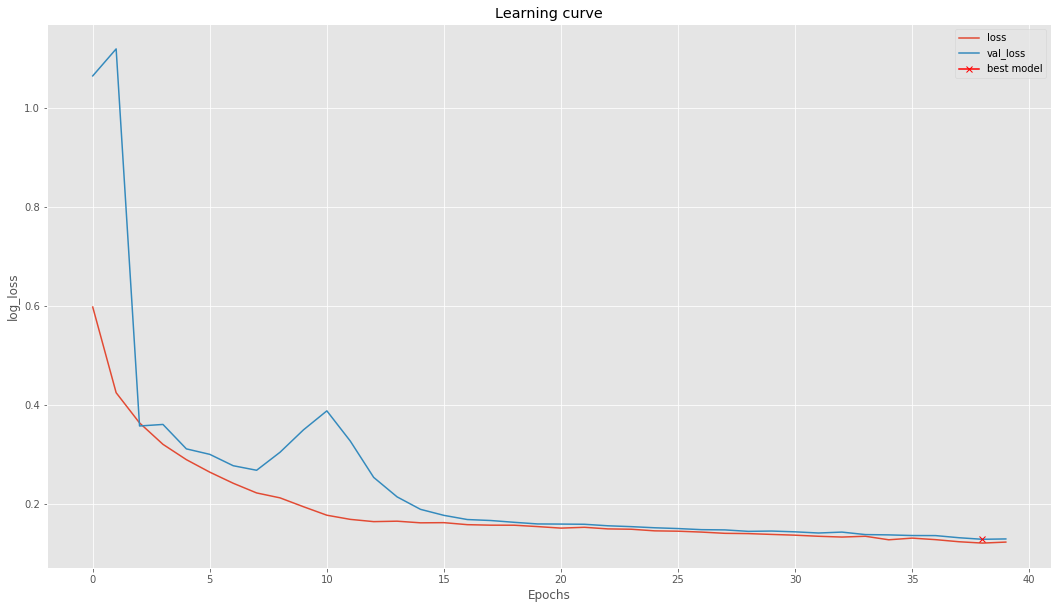

In [86]:
plt.figure(figsize=(18, 10))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]),
         np.min(results.history["val_loss"]), marker="x", color="r", 
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

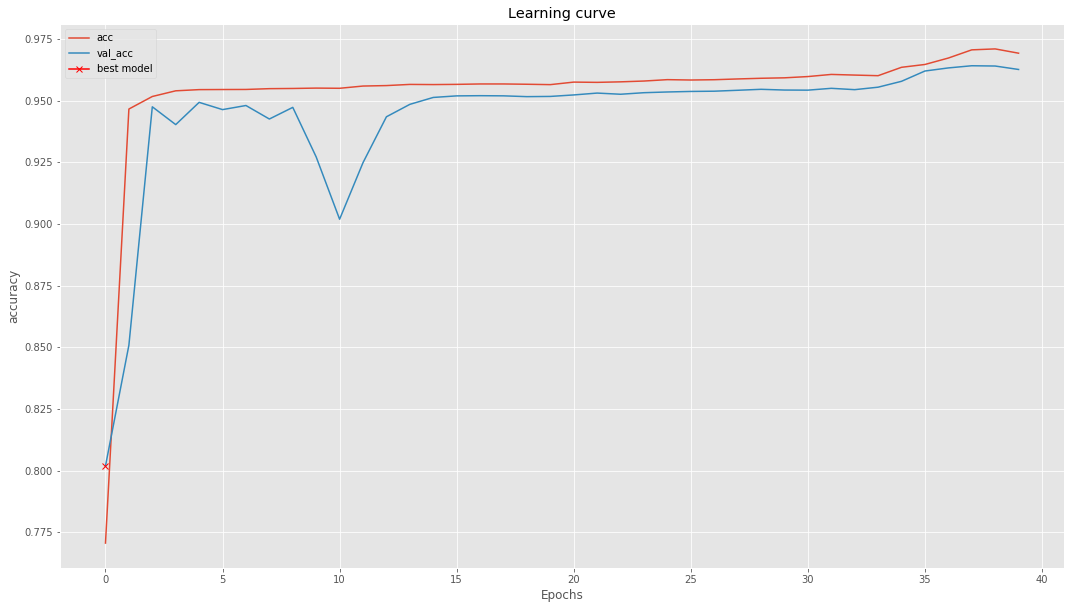

In [87]:
plt.figure(figsize=(18, 10))
plt.title("Learning curve")
plt.plot(results.history["acc"], label="acc")
plt.plot(results.history["val_acc"], label="val_acc")
plt.plot( np.argmin(results.history["val_acc"]),
         np.min(results.history["val_acc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()

In [88]:
model.load_weights('model-tgs-salt.h5')

In [89]:
model.evaluate(X_valid, y_valid, verbose=1)

30/30 [==============================] - 0s 12ms/step


[0.1293158084154129, 0.9641336798667908]

In [90]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

30/30 [==============================] - 0s 11ms/step


In [102]:
def plot_sample(X, y, preds, binary_preds):
    ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Endoscopy')
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('polyp')
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].grid(False)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('polyp Predicted') 
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

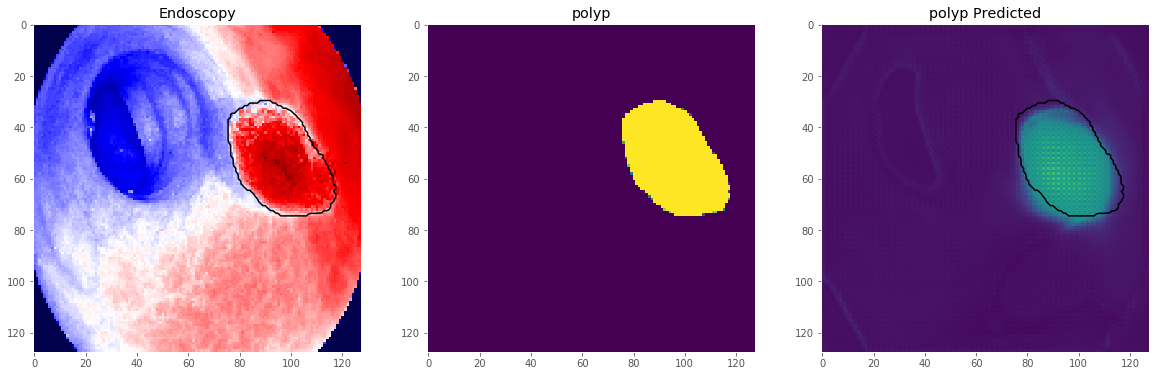

In [105]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

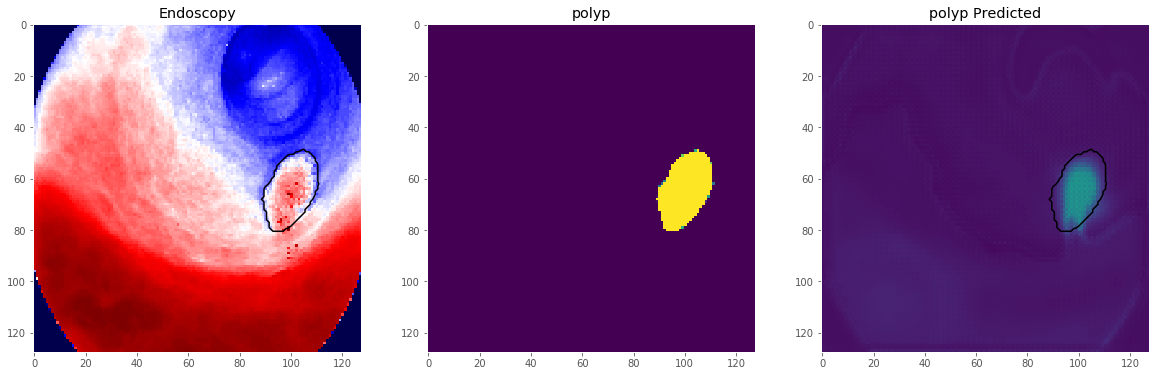

In [110]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [111]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Endoscopy')
    ax[0].grid(False)

    ax[1].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Endoscopy cumsum')
    ax[1].grid(False)

    ax[2].imshow(y[ix].squeeze())
    ax[2].set_title('Polyp')
    ax[2].grid(False)

    ax[3].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('polyp Predicted');
    ax[3].grid(False)
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

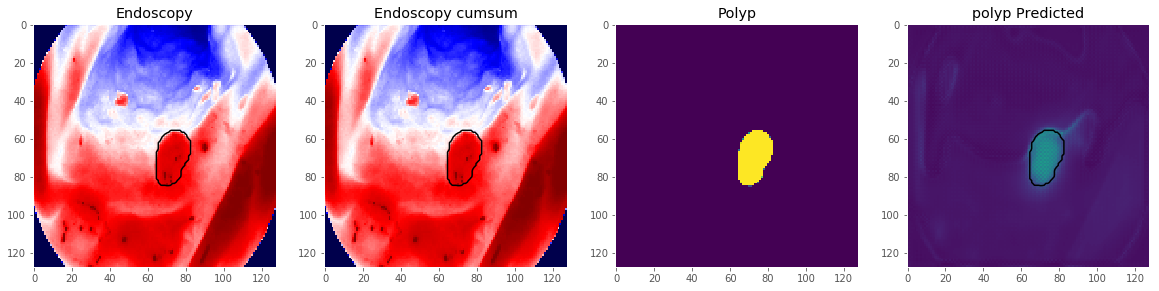

In [115]:
plot_sample(X_train, y_train, preds_train)

In [123]:
target_size = (400,400)
def show(img):
    plt.imshow(img)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
def get_img(path, color_space=cv2.COLOR_BGR2RGB):
    img = cv2.imread(path)
    if target_size:
        img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, color_space)
    return img

def select_channel(img, ch):
    return np.stack((img[:,:,ch],img[:,:,ch],img[:,:,ch])).transpose((1,2,0))

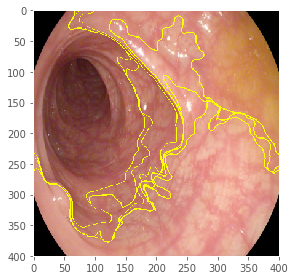

In [151]:
n_segments = 3
sigma = 5
for i, filepath in enumerate(glob.glob('Endoscopy/train/images/*.tif')):
    if i != 6:
        continue
    img = get_img(filepath, color_space=cv2.COLOR_BGR2RGB)
    R = select_channel(img, 0)
    G = select_channel(img, 1)
    B = select_channel(img, 2)
    segmentsR = slic(R, n_segments=n_segments, sigma=sigma)
    segmentsG = slic(G, n_segments=n_segments, sigma=sigma)
    segmentsB = slic(B, n_segments=n_segments, sigma=sigma)
    mark_segments = get_img(filepath, color_space=cv2.COLOR_BGR2RGB)
    mark_segments = mark_boundaries(mark_segments, segmentsR)
    mark_segments = mark_boundaries(mark_segments, segmentsG)
    mark_segments = mark_boundaries(mark_segments, segmentsB)
    show(mark_segments)

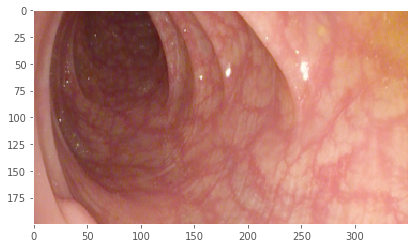

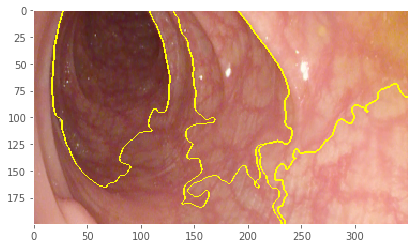

In [152]:
roi = img[100:300,:350,:]
show(roi)
scjB = slic(B[100:300,:350,:], n_segments=4, sigma=3)
scjG = slic(G[100:300,:350,:], n_segments=4, sigma=3)
mark_segments = roi.copy()
mark_segments = mark_boundaries(roi, scjB)
mark_segments = mark_boundaries(roi, scjG)
show(mark_segments)